In [1]:
# Importing Dependencies
import tensorflow as tf
from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Mounting Google Drive.  Don't have to run again if it has already been mounted.
drive.mount('/content/drive')

# Providing the Paths to the Training, Validation, and Testing data
training_path = '/content/drive/MyDrive/P4_MicroPystics/Resources/1_Training'
validation_path = '/content/drive/MyDrive/P4_MicroPystics/Resources/2_Validation'
testing_path = '/content/drive/MyDrive/P4_MicroPystics/Resources/3_Testing'

# Resizing the jpgs to 128x128 to reduce processing needs and to provide uniform images
def resize_images(image):
    resized_image = resize(image.squeeze(), (128, 128))
    return np.expand_dims(resized_image, axis=-1)

# Loading the JPGs as B&W to save memory
def rgb_to_gray(image):
    return rgb2gray(image)

# All jpgs should be the same size (128,128), however, rescaling in anticipation of Neural Networking modeling later in the process.
# Allowing for some variation in image orientation.
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=lambda x: resize(x.squeeze(), (128, 128)),
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Defining Training and Validation sets
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=924,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=230,
    class_mode='binary',
    subset='validation'
)

Mounted at /content/drive
Found 924 images belonging to 2 classes.
Found 230 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


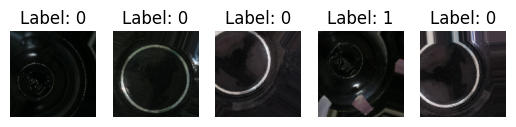

In [3]:
# Check to see what it is we loaded into the Training Set

# Loading the first batch from train_generator
batch = next(train_generator)

# Extracting the images and labels from the batch
images, labels = batch

# Displaying the first few images along with their labels
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')

plt.show()

In [ ]:
# Double checking the shape of the output from the resizing
sample_batch = next(train_generator)
sample_image = sample_batch[0][0]  # Taking the first image from the batch
print("Shape after resize_images:", sample_image.shape)

Shape after resize_images: (128, 128, 3)


In [ ]:
# Building the Image Classification Model, using Convolutional Neural Network, via MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freezing the convolutional base
base_model.trainable = False

# Modeling with classification head on top of MobileNetV2
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Training the Model
epochs = 15

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

Epoch 1/15
1/1 [==============================] - 44s 44s/step - loss: 0.5999 - accuracy: 0.6526 - val_loss: 0.6388 - val_accuracy: 0.5652
Epoch 2/15
1/1 [==============================] - 39s 39s/step - loss: 0.6686 - accuracy: 0.5866 - val_loss: 0.5905 - val_accuracy: 0.7522
Epoch 3/15
1/1 [==============================] - 39s 39s/step - loss: 0.3827 - accuracy: 0.8690 - val_loss: 0.8610 - val_accuracy: 0.6174
Epoch 4/15
1/1 [==============================] - 39s 39s/step - loss: 0.4812 - accuracy: 0.7489 - val_loss: 0.7771 - val_accuracy: 0.7000
Epoch 5/15
1/1 [==============================] - 39s 39s/step - loss: 0.3997 - accuracy: 0.8214 - val_loss: 0.5652 - val_accuracy: 0.7739
Epoch 6/15
1/1 [==============================] - 36s 36s/step - loss: 0.3144 - accuracy: 0.8874 - val_loss: 0.4714 - val_accuracy: 0.7913
Epoch 7/15
1/1 [==============================] - 35s 35s/step - loss: 0.3143 - accuracy: 0.8636 - val_loss: 0.4186 - val_accuracy: 0.8043
Epoch 8/15
1/1 [===========

In [ ]:
# Evaluating the model on the testing set
testing_generator = datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=100,
    class_mode='binary',
    shuffle=False
)

# Generating predictions on the testing set
predictions = model.predict(testing_generator)

# Converting predictions to binary values (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Getting true labels from the generator
true_labels = testing_generator.classes

# Calculating accuracy
accuracy = np.mean(binary_predictions == true_labels)
print(f'Testing Accuracy: {accuracy}')
print("True Labels:")
print(true_labels)

Found 200 images belonging to 2 classes.
2/2 [==============================] - 6s 2s/step
Testing Accuracy: 0.5
True Labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


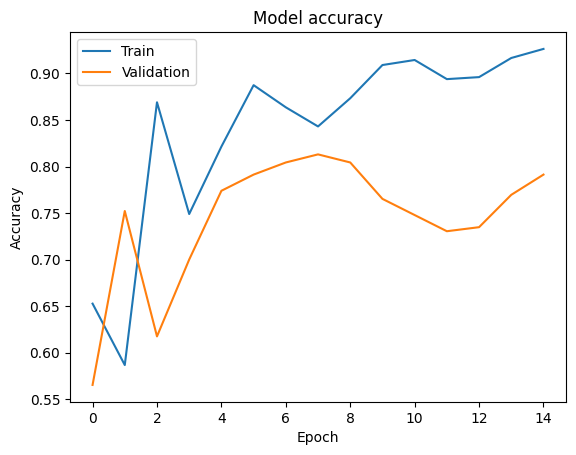

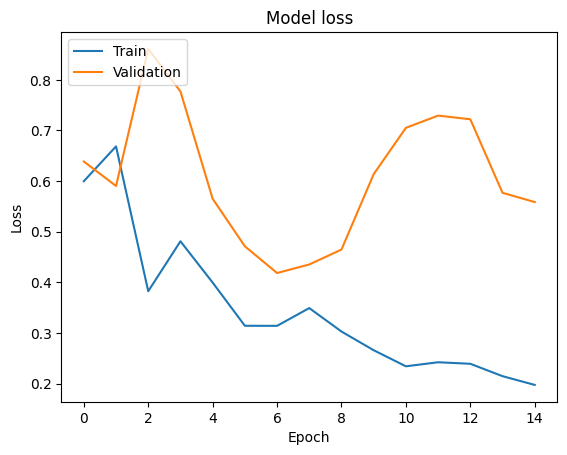

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Saving as PTH file for Interactive Model
model.save_weights('MicroPystics.h5')